In [6]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Config
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import tqdm
from safetensors.torch import save_model, load_model
from dataclasses import dataclass
import warnings
import numpy as np

# Suppress all warnings (or you could try to target a specific warning if you know its category)
warnings.filterwarnings("ignore")

In [3]:
@dataclass
class DataConfig:
    cls: type  # Type of the class this configuration is for
    total_size: int = 30000
    max_digits: int = 3
    max_length: int | None = (2 * max_digits) + 2 + (max_digits + 1)  # Use Optional[int] or int | None for nullable int
    split_ratio: float = 0.8
    seed: int = 42
    batch_size: int = 32
    num_workers: int = 0

## Tokenizer
Each digit would be cosidered as a token, and to that we will add the +, =, and PAD tokens

In [79]:
class SimpleTokenizer:
    def __init__(self, padding_side='left'):
        self.vocab = {
            **{str(i): i for i in range(10)},  # Digits 0-9
            "+": 10, "=": 11, "PAD": 12
        }
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        self.padding_side = padding_side

    def encode(self, text, max_length=9, return_tensor=True, train=False):
        tokens = [self.vocab.get(char, self.vocab["PAD"]) for char in text if char in self.vocab]
        
        # Pad the tokens based on padding side
        padding_length = max(0, max_length - len(tokens))
        
        if self.padding_side == "right":
            tokens.extend([self.vocab["PAD"]] * padding_length)
        else :
            tokens = [self.vocab["PAD"]] * padding_length + tokens
        
        # Truncate if necessary
        tokens = tokens[:max_length]

        return torch.tensor(tokens)
    def decode(self, tokens):
        return "".join([self.inv_vocab[t] for t in tokens if t != self.vocab["PAD"]])

tokenizer = SimpleTokenizer(padding_side='right')

In [80]:
input_part = '12+99=1'
tokenizer.encode(input_part, max_length=len(input_part)+2)

tensor([ 1,  2, 10,  9,  9, 11,  1, 12, 12])

## Dataset and dataloader

The dataset consists of inputs which contains the token ids of operands and the operation for additions. The numbers are each sampled from the range [0,10**max_digits[

In [81]:
class AdditionDataset(Dataset):
    def __init__(self, total_size=10000, max_digits=2, max_length=None, 
                 train=True, split_ratio=0.8, seed=42):
        """
        Args:
            total_size (int): Total number of samples (train + test)
            max_digits (int): Maximum number of digits per operand
            max_length (int): Maximum sequence length
            train (bool): True for training set, False for test set
            split_ratio (float): Proportion of data for training (0.0-1.0)
            seed (int): Random seed for reproducibility
        """
        self.max_digits = max_digits
        self.train = train
        
        # Determine max length if not specified
        if max_length is None:
            self.max_length = (2 * max_digits) + 2 + (max_digits + 1)
        else:
            self.max_length = max_length

        self.N = 10 ** max_digits  # Total numbers per operand
        self.total_pairs = min(total_size, self.N ** 2)  # Limit to total_size if smaller
        
        # Calculate dataset split sizes
        self.split_size = int(self.total_pairs * (split_ratio if train else (1 - split_ratio)))
        
        # Set up random number generators
        self.global_rng = np.random.RandomState(seed)
        
        # Generate all unique pairs
        all_pairs = set()
        while len(all_pairs) < self.total_pairs:
            i = self.global_rng.randint(0, self.N)
            j = self.global_rng.randint(0, self.N)
            all_pairs.add((i, j))
        
        # Convert to list for splitting
        all_pairs = list(all_pairs)
        
        # Split into train and test sets
        split_idx = int(self.total_pairs * split_ratio)
        
        if train:
            self.pairs = all_pairs[:split_idx]
        else:
            self.pairs = all_pairs[split_idx:]

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        # Retrieve the pre-generated unique pair
        i, j = self.pairs[idx]
        
        input_part = f"{i}+{j}="
        target_part = str(i + j)
        
        full_sequence = input_part + target_part  # Example: "12+34=46"
        
        # Tokenize
        if self.train:
            # For training: return full sequence with mask
            input_ids = tokenizer.encode(full_sequence, max_length=self.max_length)
            attention_mask = (input_ids != tokenizer.vocab["PAD"]).float()
            return input_ids, attention_mask
        else:
            # For testing: return only input part
            input_part_ids = tokenizer.encode(input_part, max_length = 2 * self.max_digits +2)
            attention_mask = (input_part_ids != tokenizer.vocab["PAD"]).float()
            
            # Optionally, you might want to include the true answer
            target_ids = tokenizer.encode(target_part, max_length = self.max_digits + 1)
            
            return input_part_ids, attention_mask, target_ids

    @classmethod
    def get_dataloaders(cls, 
                        total_size=30000, 
                        max_digits=3, 
                        max_length=None, 
                        split_ratio=0.8, 
                        seed=42, 
                        batch_size=32, 
                        num_workers=0):
        """
        Create train and test dataloaders
        
        Args:
            total_size (int): Total number of samples
            max_digits (int): Maximum number of digits per operand
            max_length (int): Maximum sequence length
            split_ratio (float): Proportion of data for training
            seed (int): Random seed for reproducibility
            batch_size (int): Batch size for dataloaders
            num_workers (int): Number of workers for dataloaders
        
        Returns:
            tuple: (train_dataloader, test_dataloader)
        """
        # Create train and test datasets
        train_dataset = cls(
            total_size=total_size, 
            max_digits=max_digits, 
            max_length=max_length, 
            train=True, 
            split_ratio=split_ratio, 
            seed=seed
        )
        
        test_dataset = cls(
            total_size=total_size, 
            max_digits=max_digits, 
            max_length=max_length, 
            train=False, 
            split_ratio=split_ratio, 
            seed=seed
        )
        
        # Create dataloaders
        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,  # Shuffle training data
            num_workers=num_workers
        )
        
        test_dataloader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,  # Don't shuffle test data
            num_workers=num_workers
        )
        
        return train_dataloader, test_dataloader

train_loader, test_loader = AdditionDataset.get_dataloaders(
    total_size=20000, 
    max_digits=3, 
    batch_size=128
)

print("Training Data:")
for batch in train_loader:
    input_ids, attention_mask = batch
    print("Train Input IDs shape:", input_ids.shape)
    print("Train Attention mask shape:", attention_mask.shape)
    print("Train Input IDs sample:", input_ids[0])
    print("Train Attention mask sample:", attention_mask[0])


    break

print("\nTesting Data:")
for batch in test_loader:
    input_ids, attention_mask, targets = batch
    print("Test Input IDs shape:", input_ids.shape)
    print("Test Attention mask shape:", attention_mask.shape)
    print("Test Target shape:", targets.shape)
    break

Training Data:
Train Input IDs shape: torch.Size([128, 12])
Train Attention mask shape: torch.Size([128, 12])
Train Input IDs sample: tensor([ 7,  1, 10,  5,  5,  0, 11,  6,  2,  1, 12, 12])
Train Attention mask sample: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

Testing Data:
Test Input IDs shape: torch.Size([128, 8])
Test Attention mask shape: torch.Size([128, 8])
Test Target shape: torch.Size([128, 4])


## GPT2 Model init:

In [82]:
config = GPT2Config(
    vocab_size=len(tokenizer.vocab),
    n_positions=DataConfig.max_length, 
    n_embd=128,
    n_layer=8,
    n_head=2,
   # bos_token_id=tokenizer.vocab['PAD'],
    #eos_token_id=tokenizer.vocab['PAD'],
    pad_token_id = tokenizer.vocab['PAD']

)
model = GPT2LMHeadModel(config)
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

In [83]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [84]:
def evaluate(model, dataloader, max_new_tokens, device, tokenizer):
    """
    Evaluate the model on the addition dataset
    
    Args:
        model: The trained model
        dataloader: Test dataloader
        max_new_tokens: Maximum number of tokens to generate
        device: Device to run inference on
        tokenizer: Tokenization utility
    """
    model.eval()
    exact_match_correct = 0
    total_samples = 0
    total_chars_correct = 0
    total_chars = 0
    total_chars_until_failure = 0
    incorrect_samples = []
    
    def character_level_until_failure(predicted, expected):
        """
        Count correct characters until first mismatch
        
        Args:
            predicted (str): Model's predicted text
            expected (str): Ground truth text
        
        Returns:
            int: Number of correct characters from the start
        """
        for i in range(min(len(predicted), len(expected))):
            if predicted[i] != expected[i]:
                return i
        return min(len(predicted), len(expected))

    for batch in dataloader:
        # Unpack the batch - now includes input_part_ids, mask, and target_ids
        input_part_ids, attention_mask, target_ids = batch

        # Move to device
        input_part_ids = input_part_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Decode target texts before generation
        target_texts = [tokenizer.decode(target.tolist()).strip() for target in target_ids]
        input_texts = [tokenizer.decode(input_part.tolist()).strip() for input_part in input_part_ids]

        with torch.inference_mode():
            outputs = model.generate(input_part_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens)  # Generate from input part

        for i, output in enumerate(outputs):
            predicted_text = tokenizer.decode(output[input_part_ids.size(1):].tolist()).strip()
            expected_text = target_texts[i]

            # Exact Match Accuracy
            if predicted_text == expected_text:
                exact_match_correct += 1

            # Character-Level Accuracy
            common_length = min(len(predicted_text), len(expected_text))
            total_chars_correct += sum(p == e for p, e in zip(predicted_text, expected_text))
            total_chars += len(expected_text)

            # Character-Level Until Failure Accuracy
            total_chars_until_failure += character_level_until_failure(predicted_text, expected_text)

            if predicted_text != expected_text:
                incorrect_samples.append((input_texts[i], predicted_text, expected_text))

            total_samples += 1

    # Compute Metrics
    exact_match_acc = exact_match_correct / total_samples
    char_level_acc = total_chars_correct / total_chars
    char_level_until_fail_acc = total_chars_until_failure / total_samples

    return {
        "exact_match_acc": exact_match_acc,
        "char_level_acc": char_level_acc,
        "char_level_until_fail_acc": char_level_until_fail_acc,
        "incorrect_samples": incorrect_samples
    }


In [85]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, epochs=200, evaluate_every = 25, device='cuda'):
    """
    Comprehensive training and evaluation workflow
    
    Args:
        model: The model to train
        train_loader: Training data loader
        test_loader: Test data loader
        optimizer: Optimizer for training
        epochs: Number of training epochs
        device: Device to run training on
        tokenizer: Tokenization utility
    
    Returns:
        dict: Training and evaluation results
    """
    # Training history tracking
    training_history = {
        'epochs': [],
        'train_losses': [],
        'metrics': []
    }
    
    # Progress bar
    progress_bar = tqdm(range(epochs), desc='Training', unit='epoch')
    
    for epoch in progress_bar:
        # Training phase
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            # Unpack input_ids and attention_mask
            input_ids, attention_mask = batch
            
            # Move to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        training_history['epochs'].append(epoch)
        training_history['train_losses'].append(avg_loss)
        
        # Evaluation phase
        if epoch % evaluate_every == 0:
            model.eval()
            with torch.inference_mode():
                # Evaluate on test set
                metrics = evaluate(model, test_loader, max_new_tokens=DataConfig.max_digits+1, device=device, tokenizer=tokenizer)
                training_history['metrics'].append(metrics)
            
        # Update progress bar
        progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
    
    # Plotting
    try:
        plt.figure(figsize=(15, 5))
        x_axis = [i * evaluate_every for i in range(len(training_history['metrics']))]
        
        # Training Loss Subplot
        plt.subplot(1, 3, 1)
        plt.plot(training_history['epochs'], training_history['train_losses'], marker='o')
        plt.title('Training Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Exact Match Accuracy Subplot
        plt.subplot(1, 3, 2)
        exact_match_acc = [metric['exact_match_acc'] for metric in training_history['metrics']]
        plt.plot(x_axis, exact_match_acc, marker='o', color='green')
        plt.title('Exact Match Accuracy')
        plt.xlabel(f'Epoch (evaluated every {evaluate_every} epochs)')
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Character-Level Accuracy Subplot
        plt.subplot(1, 3, 3)
        char_level_acc = [metric['char_level_acc'] for metric in training_history['metrics']]
        plt.plot(x_axis, char_level_acc, marker='o', color='red')
        plt.title('Character-Level Accuracy')
        plt.xlabel(f'Epoch (evaluated every {evaluate_every} epochs)')
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

    except:
        pass
    return training_history

In [87]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

Training:   0%|          | 0/300 [00:00<?, ?epoch/s]

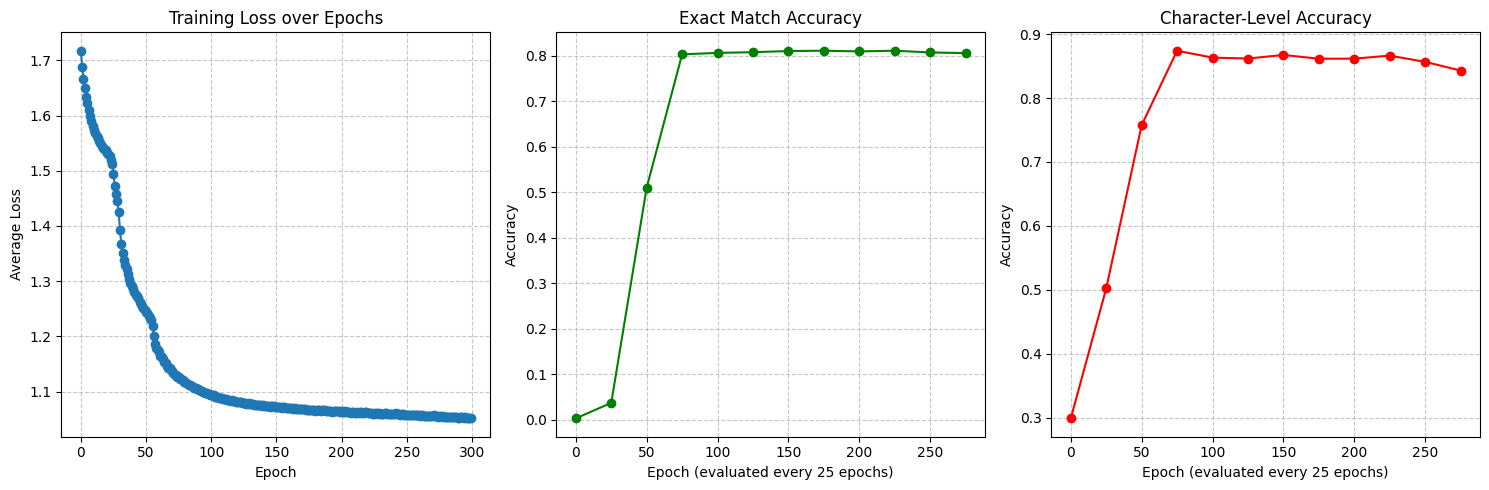

In [88]:
results = train_and_evaluate(
    model, 
    train_loader, 
    test_loader, 
    optimizer, 
    epochs=300, 
    evaluate_every = 25,
    device=device
)

In [30]:
model.eval()
with torch.inference_mode():
    # Evaluate on test set
    metrics = evaluate(model, test_loader, max_new_tokens=DataConfig.max_digits+1, device=device, tokenizer=tokenizer)

In [37]:
os.makedirs('models', exist_ok=True)
save_model(model, f"models/model.safetensors_{time.timestamp}")

In [38]:
load_model(model, "models/model.safetensors")
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(13, 128)
    (wpe): Embedding(12, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=512, nx=128)
          (c_proj): Conv1D(nf=128, nx=512)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=13, bias=False)
)

In [89]:
def predict(a, b):
    input_part = f"{a}+{b}="
    input_ids = tokenizer.encode(input_part, max_length=len(input_part)).unsqueeze(0).to(device)  # Add batch dim
    print(input_ids)
    attention_mask = (input_ids != tokenizer.vocab["PAD"]).float().to(device)
    print(attention_mask)
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=3,  # Generate up to 3 digits (e.g., "123")
            pad_token_id=tokenizer.vocab["PAD"]
        )
    print(outputs)
    generated = tokenizer.decode(outputs[0].cpu().numpy())
    return generated.split("=")[1]  # Extract the generated sum

In [96]:
predict(11, 12)

tensor([[ 1,  1, 10,  1,  2, 11]], device='cuda:0')
tensor([[1., 1., 1., 1., 1., 1.]], device='cuda:0')
tensor([[ 1,  1, 10,  1,  2, 11,  2,  3, 12]], device='cuda:0')


'23'

In [95]:
# Generate output and extract attention maps
def visualize_attention(sentence, layer_idx, head_idx):
    input_ids = tokenizer.encode(sentence, return_tensor=True, max_length=9).unsqueeze(0).to(device)  # Add batch dimension
    attention_mask = (input_ids != tokenizer.vocab["PAD"]).float().to(device)  # Create attention mask
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)

    attentions = torch.stack(outputs.attentions).squeeze(dim=1).cpu().numpy()  # Shape: (layers, heads, seq_len, seq_len)
    attn_map = attentions[layer_idx-1, head_idx-1]

    plt.figure(figsize=(8, 6))
    plt.imshow(attn_map, cmap="viridis")
    plt.colorbar()
    plt.title(f"Attention Map (Layer {layer_idx}, Head {head_idx})")
    plt.xticks(range(len(sentence)), [x for x in sentence])
    plt.yticks(range(len(sentence)), [x for x in sentence])
    plt.show()

# Interactive widgets
sentence_widget = widgets.Text(value="23+12=35", description="Sentence:")
layer_widget = widgets.IntSlider(value=1, min=1, max=len(model.transformer.h), step=1, description="Layer:")
head_widget = widgets.IntSlider(value=1, min=1, max=2, step=1, description="Head:")

ui = widgets.VBox([sentence_widget, layer_widget, head_widget])
output = widgets.Output()

def update_visualization(_):
    with output:
        output.clear_output(wait=True)
        visualize_attention(sentence_widget.value, layer_widget.value, head_widget.value)

sentence_widget.observe(update_visualization, names='value')
layer_widget.observe(update_visualization, names='value')
head_widget.observe(update_visualization, names='value')

display(ui, output)
update_visualization(None)


Output()